In [2]:
import pandas as pd
from PIL import Image, ImageFilter
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import glob
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models

In [3]:
cd /content/drive/MyDrive/nishika　画像分類

/content/drive/MyDrive/nishika　画像分類


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
print(torch.cuda.is_available())

True


In [6]:
#画像ファイルの読み込み
files = glob.glob("./data/train/*.jpg")
files = sorted(files)
train_file_list = []
for file in tqdm(files):
  file = cv2.imread(file)
  train_file_list.append(file)

100%|██████████| 4238/4238 [01:28<00:00, 47.93it/s] 


In [7]:
#テストファイル読み込み
files = glob.glob("./data/test/*.jpg")
files = sorted(files)
test_file_list = []
for file in tqdm(files):
  file = cv2.imread(file)
  test_file_list.append(file)

100%|██████████| 1060/1060 [00:24<00:00, 43.87it/s] 


In [9]:
#テンソル型に変換
train_file_list = torch.tensor(np.array(train_file_list),dtype=torch.int32)

In [10]:
test_file_list = torch.tensor(np.array(test_file_list),dtype=torch.int32)

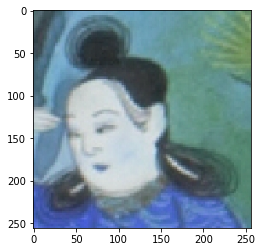

In [26]:
plt.imshow(train_file_list[0])

In [11]:
#配列を変換
train_file_list_permute = train_file_list.permute(0,3,2,1)
train_file_list_permute.size()

test_file_list_permute = test_file_list.permute(0,3,2,1)
test_file_list_permute.size()

torch.Size([1060, 3, 256, 256])

In [12]:
#ラベル読み込み
label_df = pd.read_csv('./data/train.csv')
#テンソル型に変換
label_df = torch.tensor(label_df['gender_status'],dtype=torch.int32)

In [20]:
#データセット作成
Dataset = torch.utils.data.TensorDataset(train_file_list_permute, label_df)
train_loader = DataLoader(Dataset,batch_size=32,shuffle=True)

In [21]:
#resnetを読み込み
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512,8)
model.to(device)
#勾配計算をなくす
for param in model.parameters():
  param.requires_grad = True
#誤差関数
criterion = nn.CrossEntropyLoss()
#最適化手法
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)

In [15]:
num_epochs = 50
losses = []
accs = []
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  for imgs, labels in train_loader:
    imgs = imgs.float()
    labels = labels.type(torch.LongTensor) 
    imgs = imgs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output,labels)
    running_loss += loss.item()
    pred = torch.argmax(output,dim=1)
    running_acc += torch.mean(pred.eq(labels).float())
    loss.backward()
    optimizer.step()
  running_loss /= len(train_loader)
  running_acc /= len(train_loader)
  losses.append(running_loss)
  accs.append(running_acc)
  print('エポック:{}.loss:{}.acc{}.'.format(epoch,running_loss,running_acc))


エポック:0.loss:1.4024376340378495.acc0.4638158082962036.
エポック:1.loss:1.0930835044473635.acc0.6077470779418945.
エポック:2.loss:0.9862361949189264.acc0.6418837308883667.
エポック:3.loss:0.9222239450852674.acc0.675382673740387.
エポック:4.loss:0.9015539642563439.acc0.6724288463592529.
エポック:5.loss:0.8528566739164797.acc0.6875671148300171.
エポック:6.loss:0.8418713427127752.acc0.6910244822502136.
エポック:7.loss:0.8252274400757668.acc0.6977376937866211.
エポック:8.loss:0.8128227105266169.acc0.6955894231796265.
エポック:9.loss:0.7884086397357453.acc0.7120704054832458.
エポック:10.loss:0.7729271132695047.acc0.7159304618835449.
エポック:11.loss:0.7710176022877371.acc0.7150577306747437.
エポック:12.loss:0.7520087049867874.acc0.7299275398254395.
エポック:13.loss:0.7505517917916291.acc0.7299946546554565.
エポック:14.loss:0.7296060296825897.acc0.7315050959587097.
エポック:15.loss:0.7527231594225517.acc0.7195219993591309.
エポック:16.loss:0.742064658860515.acc0.7202940583229065.
エポック:17.loss:0.732539324159909.acc0.7310351729393005.
エポック:18.loss:0.71491664

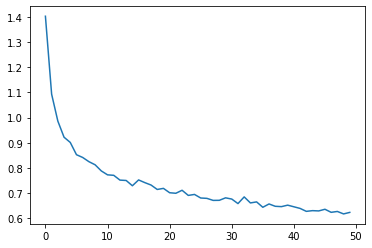

In [23]:
plt.plot(losses)

In [32]:
model.eval()

t_pred = []
for x in test_file_list_permute:
    x = x.float()
    x = x.to(device)
    # 順伝播
    x = x.unsqueeze(0)
    y = model.forward(x)

    # モデルの出力を予測値のスカラーに変換
    pred = y.argmax(1).tolist()

    t_pred.extend(pred)

In [34]:
submission = pd.read_csv('/content/drive/MyDrive/nishika　画像分類/data/sample_submission.csv')

In [37]:
submission['gender_status'] = t_pred

In [40]:
submission.to_csv( "/content/drive/MyDrive/nishika　画像分類/コード/submisson1.csv",index=False)